<a href="https://colab.research.google.com/github/mvajhi/unsupervised-learning/blob/master/HW3/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

length of the training set: 60000
length of the test set: 10000


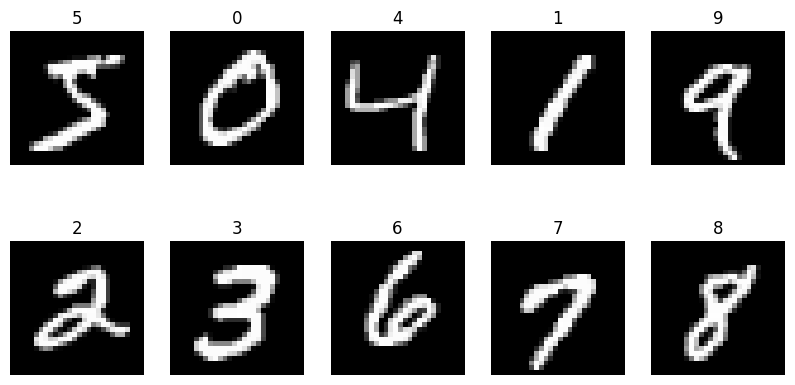

In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = torchvision.transforms.ToTensor()
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print('length of the training set: {}'.format(len(mnist_trainset)))
print('length of the test set: {}'.format(len(mnist_testset)))


figure = plt.figure(figsize=(10, 5))
cols, rows = 5, 2
displayed_labels = []

for img, label in mnist_trainset:
    if len(displayed_labels) == 10:
        break
    if label not in displayed_labels:
        ax = figure.add_subplot(rows, cols, len(displayed_labels) + 1)
        ax.set_title((label))
        ax.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
        displayed_labels.append(label)

plt.show()

# Preprocessing Step

برای انتخاب ۲۰۰ داده ۲۰۰ کلاستر می کنیم داده های آموزشی را سپس داده مرکزی هر کلاستر را انتخاب می کنیم. به این صورت ۲۰۰ داده خوبی را انتخاب کردیم.

In [2]:
from sklearn.cluster import KMeans
from scipy.spatial import distance
import numpy as np
from tqdm import tqdm

train_images_np = mnist_trainset.data.numpy()
train_labels_np = mnist_trainset.targets.numpy()
test_images_np = mnist_testset.data.numpy()
test_labels_np = mnist_testset.targets.numpy()

n_samples, nx, ny = train_images_np.shape
train_images_flattened = train_images_np.reshape((n_samples, -1))


n_clusters = 200
# kmeans = KMeans(n_clusters=n_clusters)
# kmeans.fit(train_images_flattened)

# selected_indices = []

# distances = kmeans.transform(train_images_flattened)

# for i in tqdm(range(n_clusters), desc="select sample"):
#     indices_in_cluster = np.where(kmeans.labels_ == i)[0]
#     cluster_distances = distances[indices_in_cluster, i]
#     index_of_closest_in_cluster = np.argmin(cluster_distances)
#     original_index = indices_in_cluster[index_of_closest_in_cluster]
#     selected_indices.append(original_index)

# print(selected_indices)

selected_indices = [np.int64(39080), np.int64(25982), np.int64(19671), np.int64(39666), np.int64(34544), np.int64(51290), np.int64(11431), np.int64(44233), np.int64(32736), np.int64(53153), np.int64(56550), np.int64(19880), np.int64(59332), np.int64(15984), np.int64(14422), np.int64(11360), np.int64(9319), np.int64(52606), np.int64(57946), np.int64(54614), np.int64(46382), np.int64(15583), np.int64(5087), np.int64(33815), np.int64(5209), np.int64(3632), np.int64(6561), np.int64(55415), np.int64(33305), np.int64(43049), np.int64(50163), np.int64(13151), np.int64(37549), np.int64(157), np.int64(18538), np.int64(43160), np.int64(54733), np.int64(28938), np.int64(43253), np.int64(25152), np.int64(10529), np.int64(12653), np.int64(33052), np.int64(27308), np.int64(5657), np.int64(36198), np.int64(28118), np.int64(50825), np.int64(21533), np.int64(51359), np.int64(46160), np.int64(13445), np.int64(5980), np.int64(7747), np.int64(59223), np.int64(59803), np.int64(24846), np.int64(54208), np.int64(28039), np.int64(1753), np.int64(41886), np.int64(36288), np.int64(4035), np.int64(23639), np.int64(50213), np.int64(32508), np.int64(26130), np.int64(43876), np.int64(50900), np.int64(50209), np.int64(6567), np.int64(25370), np.int64(2945), np.int64(34513), np.int64(2057), np.int64(46220), np.int64(45146), np.int64(9848), np.int64(41868), np.int64(35101), np.int64(18576), np.int64(59540), np.int64(10619), np.int64(347), np.int64(3188), np.int64(4697), np.int64(31783), np.int64(53810), np.int64(53697), np.int64(49611), np.int64(32810), np.int64(6642), np.int64(56699), np.int64(17267), np.int64(18013), np.int64(6031), np.int64(34797), np.int64(28069), np.int64(23485), np.int64(33171), np.int64(14251), np.int64(46620), np.int64(21755), np.int64(7137), np.int64(18243), np.int64(13228), np.int64(45231), np.int64(55662), np.int64(36990), np.int64(49341), np.int64(59499), np.int64(25169), np.int64(44215), np.int64(25838), np.int64(14066), np.int64(45762), np.int64(3154), np.int64(19659), np.int64(18047), np.int64(45501), np.int64(6434), np.int64(13479), np.int64(19409), np.int64(58714), np.int64(33094), np.int64(11095), np.int64(56984), np.int64(6124), np.int64(5256), np.int64(34256), np.int64(16608), np.int64(951), np.int64(27160), np.int64(51817), np.int64(4895), np.int64(51040), np.int64(54241), np.int64(51224), np.int64(19470), np.int64(37454), np.int64(32983), np.int64(27064), np.int64(427), np.int64(33796), np.int64(42185), np.int64(1218), np.int64(27662), np.int64(44892), np.int64(14425), np.int64(58524), np.int64(31716), np.int64(15299), np.int64(23178), np.int64(27321), np.int64(47900), np.int64(31425), np.int64(27668), np.int64(973), np.int64(44735), np.int64(3143), np.int64(46246), np.int64(34350), np.int64(24766), np.int64(38233), np.int64(98), np.int64(13050), np.int64(3575), np.int64(10343), np.int64(2377), np.int64(3213), np.int64(25363), np.int64(52724), np.int64(26282), np.int64(35213), np.int64(20377), np.int64(48779), np.int64(48924), np.int64(38234), np.int64(23777), np.int64(20147), np.int64(16767), np.int64(21764), np.int64(13891), np.int64(3201), np.int64(36677), np.int64(6635), np.int64(52192), np.int64(48736), np.int64(13231), np.int64(20033), np.int64(43170), np.int64(36493), np.int64(49018), np.int64(21163), np.int64(56531), np.int64(8820), np.int64(23599), np.int64(15437), np.int64(10447), np.int64(2033)]

all_indices = np.arange(len(train_images_np))
unlabeled_indices = np.setdiff1d(all_indices, selected_indices)

train_x = train_images_np[selected_indices]
train_y_raw = train_labels_np[selected_indices]

train_unlabeled = train_images_np[unlabeled_indices]

test_x = test_images_np
test_y_raw = test_labels_np

In [3]:
from sklearn.preprocessing import OneHotEncoder

def one_hot(y):
  #For converting a numpy array of 0-9 into a one hot encoding of vectors of length 10
  b = np.zeros((y.size, y.max() + 1))
  b[np.arange(y.size), y] = 1
  return b.astype(np.float32)

train_y = one_hot(train_y_raw)
test_y = one_hot(test_y_raw)

train_x = train_x.reshape(train_x.shape[0], 1, 28, 28).astype(np.float32)
train_unlabeled = train_unlabeled.reshape(train_unlabeled.shape[0], 1, 28, 28).astype(np.float32)
test_x = test_x.reshape(test_x.shape[0], 1, 28, 28).astype(np.float32)

torch_train_x = torch.tensor(train_x, requires_grad=True).to(device)
torch_train_y = torch.tensor(train_y).to(device)
torch_test_x = torch.tensor(test_x, requires_grad=True).to(device)
torch_test_y = torch.tensor(test_y).to(device)
torch_train_unlabeled = torch.tensor(train_unlabeled, requires_grad=True).to(device)

# Defining Model

In [4]:
import torch.nn.functional as F
import torch.nn as nn

class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(1,16,3)
        self.conv2 = nn.Conv2d(16,16,3)
        self.conv3 = nn.Conv2d(16,32,3)

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1)
        return x

#defining model head
class Head(nn.Module):
    def __init__(self, n_class=10):
        super(Head, self).__init__()
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, n_class)

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = Backbone()
        self.head = Head()

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

model_baseline = Model()
print(model_baseline(torch_train_x[:1]).shape)
model_baseline

torch.Size([1, 10])


Model(
  (backbone): Backbone(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (head): Head(
    (fc1): Linear(in_features=32, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=10, bias=True)
  )
)

# Train without unlabeled data

100%|██████████| 2500/2500 [01:28<00:00, 28.23it/s]


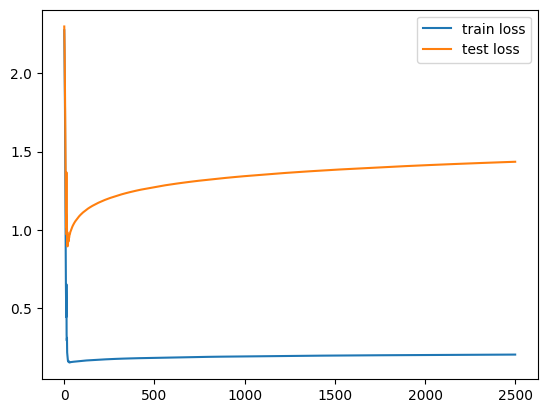

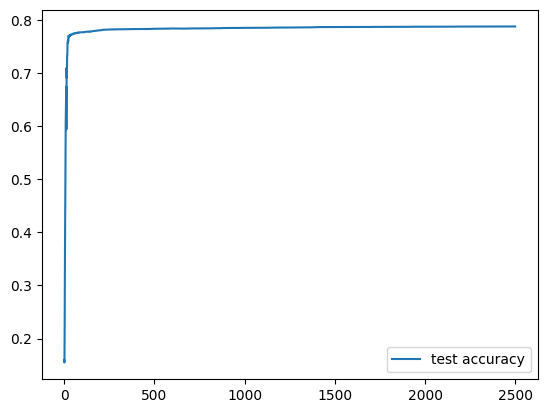

max accuracy: 0.7873


In [5]:
def supervised_train(model):

    batch_size = 32
    lr = 0.001
    momentum = 0.9
    num_epochs = 2500

    #defining a stocastic gradient descent optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    #defining loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    train_hist = []
    test_hist = []
    test_accuracy = []

    for epoch in tqdm(range(num_epochs)):

        #iterating over all batches
        for i in range(int(len(train_x)/batch_size)-1):

            #Put the model in training mode, so that things like dropout work
            model.train(True)


            # Zero gradients for the optimizer
            optimizer.zero_grad()


            #extracting X and y values from the batch
            X = torch_train_x[i*batch_size: (i+1)*batch_size]
            y = torch_train_y[i*batch_size: (i+1)*batch_size]

            # Make predictions for this batch
            y_pred = model(X)

            #compute gradients with the loss function
            loss = loss_fn(y_pred, y)
            loss.backward()


            # Adjust learning weights
            optimizer.step()

        with torch.no_grad():

            #Disable things like dropout, if they exist
            model.train(False)

            #calculating epoch training and test loss
            train_loss = loss_fn(model(torch_train_x), torch_train_y).cpu().numpy()
            y_pred_test = model(torch_test_x)
            test_loss = loss_fn(y_pred_test, torch_test_y).cpu().numpy()

            train_hist.append(train_loss) # use train loss to plot
            test_hist.append(test_loss) # use test loss to plot

            #computing test accuracy
            matches = np.equal(np.argmax(y_pred_test.cpu().numpy(), axis=1), np.argmax(torch_test_y.cpu().numpy(), axis=1))
            test_accuracy.append(np.mean(matches))

    import matplotlib.pyplot as plt
    plt.plot(train_hist, label = 'train loss')
    plt.plot(test_hist, label = 'test loss')
    plt.legend()
    plt.show()
    plt.plot(test_accuracy, label = 'test accuracy')
    plt.legend()
    plt.show()

    maxacc = np.max(test_accuracy)
    print('max accuracy: {}'.format(maxacc))

    return maxacc

supervised_maxacc = supervised_train(model_baseline)

بله، دقت به دست آمده مشخصا بالاتر از Chance Level هست.

# Data Augmentation

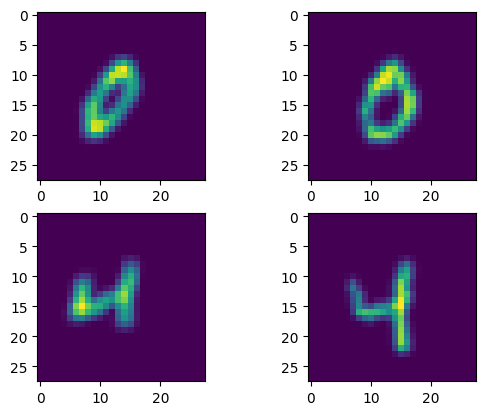

In [6]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

class Augment:

   def __init__(self):

       blur = T.GaussianBlur((3,3))

       self.train_transform = torch.nn.Sequential(
           T.RandomAffine(45),
           T.RandomPerspective(),
           T.RandomPerspective(),
           T.RandomPerspective(0.2,0.5),
           T.RandomApply([blur]),
           T.RandomApply([blur])
       )

   def __call__(self, x):
       return self.train_transform(x), self.train_transform(x)

"""
Generating Test Augmentation
"""
a = Augment()
aug = a(torch_train_unlabeled[0:100])

i=1
f, axarr = plt.subplots(2,2)
#positive pair
axarr[0,0].imshow(aug[0].cpu().detach().numpy()[i,0])
axarr[0,1].imshow(aug[1].cpu().detach().numpy()[i,0])
#another positive pair
axarr[1,0].imshow(aug[0].cpu().detach().numpy()[i+1,0])
axarr[1,1].imshow(aug[1].cpu().detach().numpy()[i+1,0])
plt.show()

# Defining Contrastive Loss

In [9]:
# class ContrastiveLoss(nn.Module):
#    def __init__(self, batch_size, temperature=0.5):

#        super().__init__()
#        self.batch_size = batch_size
#        self.temperature = temperature
#        self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(device)

#    def calc_similarity_batch(self, a, b):
#        representations = torch.cat([a, b], dim=0)
#        return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

#    def forward(self, proj_1, proj_2):
#        batch_size = proj_1.shape[0]
#        z_i = F.normalize(proj_1, p=2, dim=1)
#        z_j = F.normalize(proj_2, p=2, dim=1)

#        similarity_matrix = self.calc_similarity_batch(z_i, z_j)

#        sim_ij = torch.diag(similarity_matrix, batch_size)
#        sim_ji = torch.diag(similarity_matrix, -batch_size)

#        positives = torch.cat([sim_ij, sim_ji], dim=0)

#        nominator = torch.exp(positives / self.temperature)

#        denominator = self.mask * torch.exp(similarity_matrix / self.temperature)

#        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
#        loss = torch.sum(all_losses) / (2 * self.batch_size)
#        return loss

class ContrastiveLoss(nn.Module):
   def __init__(self, temperature=0.5):
       super().__init__()
       self.temperature = temperature

   def calc_similarity_batch(self, a, b):
       representations = torch.cat([a, b], dim=0)
       return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

   def forward(self, proj_1, proj_2):
       batch_size = proj_1.shape[0]
       z_i = F.normalize(proj_1, p=2, dim=1)
       z_j = F.normalize(proj_2, p=2, dim=1)
       
       similarity_matrix = self.calc_similarity_batch(z_i, z_j)
       
       mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(device)
       sim_ij = torch.diag(similarity_matrix, batch_size)
       sim_ji = torch.diag(similarity_matrix, -batch_size)
       
       positives = torch.cat([sim_ij, sim_ji], dim=0)
       
       nominator = torch.exp(positives / self.temperature)
       
       denominator = mask * torch.exp(similarity_matrix / self.temperature)
       
       all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
       loss = torch.sum(all_losses) / (2 * batch_size)
       return loss

loss = ContrastiveLoss()
fake_proj_0, fake_proj_1 = a(torch_train_x)
fake_proj_0 = fake_proj_0[:,0,:,0]
fake_proj_1 = fake_proj_1[:,0,:,0]
loss(fake_proj_0, fake_proj_1)

tensor(5.9836, device='cuda:0', grad_fn=<DivBackward0>)

# Training on whole data

In [14]:
from torch.optim.lr_scheduler import ExponentialLR

model = Model()
model.train()

#defining key hyperparameters
batch_size = 512
epoch_size = int(len(torch_train_unlabeled) / batch_size)
num_epochs = 51
patience = 5
cutoff_ratio = 0.001

#defining key learning functions
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_examples = len(torch_train_unlabeled)
lossfn = ContrastiveLoss()
augmentfn = Augment()

#for book keeping
loss_hist = []
improvement_hist = []
schedule_hist = []

#for exponentially decreasing learning rate
scheduler = ExponentialLR(optimizer, gamma = 0.95)

#for early stopping
patience_count = 0

#Training Loop
avg_loss = 1e10
for i in range(num_epochs):

    print('epoch {}/{}'.format(i,num_epochs))

    total_loss = 0
    loss_change = 0

    for j in tqdm(range(epoch_size)):

        #getting random batch
        X = torch_train_unlabeled[j*batch_size: (j+1)*batch_size]

        #creating pairs of augmented batches
        X_aug_i, X_aug_j = augmentfn(X)

        #ensuring gradients are zero
        optimizer.zero_grad()

        #passing through the model
        z_i = model(X_aug_i) 
        z_j = model(X_aug_j) 

        #calculating loss on the model embeddings, and computing gradients
        loss = lossfn(z_i, z_j)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        if True:
            z_i = model(X_aug_i)
            z_j = model(X_aug_j)

            #calculating new loss value
            new_loss = lossfn(z_i, z_j)

            loss_change += new_loss.cpu().detach().numpy() - loss.cpu().detach().numpy()

        total_loss += loss.item()

        #step learning rate scheduler
        schedule_hist.append(scheduler.get_last_lr())

    #########################
    # update scheduler here #
    scheduler.step()
    #########################

    #calculating percentage loss reduction
    new_avg_loss = total_loss/epoch_size
    per_loss_reduction = (avg_loss-new_avg_loss)/avg_loss
    print('Percentage Loss Reduction: {}'.format(per_loss_reduction))

    #deciding to stop if loss is not decreasing fast enough
    if per_loss_reduction < cutoff_ratio:
        patience_count+=1
        print('patience counter: {}'.format(patience_count))
        if patience_count > patience:
            break
    else:
        patience_count = 0

    #setting new loss as previous loss
    avg_loss = new_avg_loss

    #book keeping
    avg_improvement = loss_change/epoch_size
    loss_hist.append(avg_loss)
    improvement_hist.append(avg_improvement)
    print('Average Loss: {}'.format(avg_loss))
    print('Average Loss change (if calculated): {}'.format(avg_improvement))

epoch 0/51


100%|██████████| 116/116 [00:28<00:00,  4.04it/s]


Percentage Loss Reduction: 0.9999999993132732
Average Loss: 6.86726792927446
Average Loss change (if calculated): -0.024477078996855636
epoch 1/51


100%|██████████| 116/116 [00:28<00:00,  4.02it/s]


Percentage Loss Reduction: 0.05333243710322212
Average Loss: 6.5010197943654555
Average Loss change (if calculated): -0.03990465608136407
epoch 2/51


100%|██████████| 116/116 [00:29<00:00,  3.92it/s]


Percentage Loss Reduction: 0.03742759662515055
Average Loss: 6.257702247849826
Average Loss change (if calculated): -0.0294464662157256
epoch 3/51


100%|██████████| 116/116 [00:29<00:00,  3.92it/s]


Percentage Loss Reduction: 0.0014050682930930377
Average Loss: 6.248909748833755
Average Loss change (if calculated): -0.03137489845012796
epoch 4/51


100%|██████████| 116/116 [00:29<00:00,  3.94it/s]


Percentage Loss Reduction: 0.008298458861483683
Average Loss: 6.197053428353934
Average Loss change (if calculated): -0.026176501964700633
epoch 5/51


100%|██████████| 116/116 [00:29<00:00,  3.93it/s]


Percentage Loss Reduction: 0.018160883476199638
Average Loss: 6.084509463145815
Average Loss change (if calculated): -0.018823286582683695
epoch 6/51


100%|██████████| 116/116 [00:29<00:00,  3.97it/s]


Percentage Loss Reduction: 0.004578784056233475
Average Loss: 6.056649808225961
Average Loss change (if calculated): -0.019535286673184098
epoch 7/51


100%|██████████| 116/116 [00:29<00:00,  3.97it/s]


Percentage Loss Reduction: 0.010524172553208781
Average Loss: 5.992908580549832
Average Loss change (if calculated): -0.01701000641132223
epoch 8/51


100%|██████████| 116/116 [00:28<00:00,  4.03it/s]


Percentage Loss Reduction: 0.0010438614834515883
Average Loss: 5.98665281410875
Average Loss change (if calculated): -0.018297766817027127
epoch 9/51


100%|██████████| 116/116 [00:29<00:00,  3.99it/s]


Percentage Loss Reduction: -0.003339062352695724
patience counter: 1
Average Loss: 6.006642621139
Average Loss change (if calculated): -0.020731942407016098
epoch 10/51


100%|██████████| 116/116 [00:29<00:00,  3.97it/s]


Percentage Loss Reduction: 0.012923545003826739
Average Loss: 5.929015504902806
Average Loss change (if calculated): -0.01320443893301076
epoch 11/51


100%|██████████| 116/116 [00:29<00:00,  3.98it/s]


Percentage Loss Reduction: -0.009203151341787928
patience counter: 1
Average Loss: 5.983581131902234
Average Loss change (if calculated): -0.016633444818957097
epoch 12/51


100%|██████████| 116/116 [00:28<00:00,  4.01it/s]


Percentage Loss Reduction: 0.014594582206479415
Average Loss: 5.896253265183548
Average Loss change (if calculated): -0.011477116880745724
epoch 13/51


100%|██████████| 116/116 [00:28<00:00,  4.03it/s]


Percentage Loss Reduction: -0.0032460401504298417
patience counter: 1
Average Loss: 5.915392740019437
Average Loss change (if calculated): -0.013983529189537311
epoch 14/51


100%|██████████| 116/116 [00:28<00:00,  4.03it/s]


Percentage Loss Reduction: 0.002084808315853776
Average Loss: 5.903060280043503
Average Loss change (if calculated): -0.012080344660528776
epoch 15/51


100%|██████████| 116/116 [00:28<00:00,  4.02it/s]


Percentage Loss Reduction: 0.0028117693167963274
Average Loss: 5.886462236272878
Average Loss change (if calculated): -0.012391838534124967
epoch 16/51


100%|██████████| 116/116 [00:28<00:00,  4.02it/s]


Percentage Loss Reduction: 0.0009021894229533058
patience counter: 1
Average Loss: 5.881151532304698
Average Loss change (if calculated): -0.012032385530142948
epoch 17/51


100%|██████████| 116/116 [00:28<00:00,  4.02it/s]


Percentage Loss Reduction: 0.0071433209050435695
Average Loss: 5.839140579618257
Average Loss change (if calculated): -0.009167695867604223
epoch 18/51


100%|██████████| 116/116 [00:28<00:00,  4.01it/s]


Percentage Loss Reduction: -0.0006610697167372339
patience counter: 1
Average Loss: 5.843000658627214
Average Loss change (if calculated): -0.008869787742351663
epoch 19/51


100%|██████████| 116/116 [00:28<00:00,  4.02it/s]


Percentage Loss Reduction: 0.005046616541649671
Average Loss: 5.813513274850516
Average Loss change (if calculated): -0.006816609152432145
epoch 20/51


100%|██████████| 116/116 [00:28<00:00,  4.02it/s]


Percentage Loss Reduction: -0.004980832136236415
patience counter: 1
Average Loss: 5.8424694085943285
Average Loss change (if calculated): -0.008654795843979409
epoch 21/51


100%|██████████| 116/116 [00:29<00:00,  4.00it/s]


Percentage Loss Reduction: 0.0023134628025452933
Average Loss: 5.828953072942537
Average Loss change (if calculated): -0.007487058639526367
epoch 22/51


100%|██████████| 116/116 [00:29<00:00,  3.97it/s]


Percentage Loss Reduction: 0.0007485589271686485
patience counter: 1
Average Loss: 5.8245897580837385
Average Loss change (if calculated): -0.008103267899874983
epoch 23/51


100%|██████████| 116/116 [00:29<00:00,  3.97it/s]


Percentage Loss Reduction: 0.0003290245806838946
patience counter: 2
Average Loss: 5.822673324880929
Average Loss change (if calculated): -0.007174216467758705
epoch 24/51


100%|██████████| 116/116 [00:29<00:00,  3.98it/s]


Percentage Loss Reduction: 0.006990039264222581
Average Loss: 5.78197260971727
Average Loss change (if calculated): -0.0063370301805693524
epoch 25/51


100%|██████████| 116/116 [00:29<00:00,  3.98it/s]


Percentage Loss Reduction: -0.0019240854957878915
patience counter: 1
Average Loss: 5.79309761935267
Average Loss change (if calculated): -0.006263375282287598
epoch 26/51


100%|██████████| 116/116 [00:28<00:00,  4.01it/s]


Percentage Loss Reduction: 0.003257143794518129
Average Loss: 5.774228667390758
Average Loss change (if calculated): -0.005691548873638284
epoch 27/51


100%|██████████| 116/116 [00:28<00:00,  4.01it/s]


Percentage Loss Reduction: -0.011310783371247869
patience counter: 1
Average Loss: 5.839539716983664
Average Loss change (if calculated): -0.007712392971433443
epoch 28/51


100%|██████████| 116/116 [00:28<00:00,  4.03it/s]


Percentage Loss Reduction: 0.007392547552941554
Average Loss: 5.796370641938571
Average Loss change (if calculated): -0.0062186389133847995
epoch 29/51


100%|██████████| 116/116 [00:28<00:00,  4.03it/s]


Percentage Loss Reduction: 0.0012650670844143342
Average Loss: 5.789037844230389
Average Loss change (if calculated): -0.005166522387800546
epoch 30/51


100%|██████████| 116/116 [00:28<00:00,  4.03it/s]


Percentage Loss Reduction: 0.001434504829551263
Average Loss: 5.780733441484386
Average Loss change (if calculated): -0.0050917863845825195
epoch 31/51


100%|██████████| 116/116 [00:28<00:00,  4.02it/s]


Percentage Loss Reduction: 0.0005541632673213413
patience counter: 1
Average Loss: 5.777529971352939
Average Loss change (if calculated): -0.004595456452205263
epoch 32/51


100%|██████████| 116/116 [00:29<00:00,  3.98it/s]


Percentage Loss Reduction: 0.005984362449173627
Average Loss: 5.742955137943399
Average Loss change (if calculated): -0.003882552015370336
epoch 33/51


100%|██████████| 116/116 [00:28<00:00,  4.02it/s]


Percentage Loss Reduction: -0.011569484094029163
patience counter: 1
Average Loss: 5.809398166064558
Average Loss change (if calculated): -0.005933539620761214
epoch 34/51


100%|██████████| 116/116 [00:28<00:00,  4.03it/s]


Percentage Loss Reduction: 0.004776235814229452
Average Loss: 5.781651110484682
Average Loss change (if calculated): -0.0049174448539470806
epoch 35/51


100%|██████████| 116/116 [00:29<00:00,  4.00it/s]


Percentage Loss Reduction: 0.0013536358430133071
Average Loss: 5.773824860309732
Average Loss change (if calculated): -0.0041826634571470065
epoch 36/51


100%|██████████| 116/116 [00:29<00:00,  3.98it/s]


Percentage Loss Reduction: -0.002464140141670067
patience counter: 1
Average Loss: 5.788052373918994
Average Loss change (if calculated): -0.004593812186142494
epoch 37/51


100%|██████████| 116/116 [00:28<00:00,  4.03it/s]


Percentage Loss Reduction: -0.004936363491399264
patience counter: 2
Average Loss: 5.8166243043439145
Average Loss change (if calculated): -0.004650868218520592
epoch 38/51


100%|██████████| 116/116 [00:28<00:00,  4.04it/s]


Percentage Loss Reduction: 0.013718047713670474
Average Loss: 5.736831574604429
Average Loss change (if calculated): -0.0030169158146299167
epoch 39/51


100%|██████████| 116/116 [00:28<00:00,  4.03it/s]


Percentage Loss Reduction: 0.00044075334171035104
patience counter: 1
Average Loss: 5.734303046917093
Average Loss change (if calculated): -0.0029821436980675005
epoch 40/51


100%|██████████| 116/116 [00:28<00:00,  4.01it/s]


Percentage Loss Reduction: -0.008012939712979422
patience counter: 2
Average Loss: 5.780251671527994
Average Loss change (if calculated): -0.0038220471349255792
epoch 41/51


100%|██████████| 116/116 [00:28<00:00,  4.03it/s]


Percentage Loss Reduction: 0.0020403258649220233
Average Loss: 5.768458074536817
Average Loss change (if calculated): -0.0030357221077228413
epoch 42/51


100%|██████████| 116/116 [00:28<00:00,  4.01it/s]


Percentage Loss Reduction: -0.00637982363330363
patience counter: 1
Average Loss: 5.805259819688468
Average Loss change (if calculated): -0.0035766075397359915
epoch 43/51


100%|██████████| 116/116 [00:29<00:00,  4.00it/s]


Percentage Loss Reduction: 0.010480232933214803
Average Loss: 5.7444193445403
Average Loss change (if calculated): -0.0026162122857981713
epoch 44/51


100%|██████████| 116/116 [00:29<00:00,  3.98it/s]


Percentage Loss Reduction: -0.0018304184161300207
patience counter: 1
Average Loss: 5.75493403549852
Average Loss change (if calculated): -0.003164414701790645
epoch 45/51


100%|██████████| 116/116 [00:29<00:00,  3.99it/s]


Percentage Loss Reduction: 0.0021542239459689926
Average Loss: 5.742536618791777
Average Loss change (if calculated): -0.00250099856277992
epoch 46/51


100%|██████████| 116/116 [00:28<00:00,  4.00it/s]


Percentage Loss Reduction: -0.00016557660825463767
patience counter: 1
Average Loss: 5.743487448527895
Average Loss change (if calculated): -0.002233102403838059
epoch 47/51


100%|██████████| 116/116 [00:29<00:00,  3.99it/s]


Percentage Loss Reduction: 5.7449238713887136e-05
patience counter: 2
Average Loss: 5.743157489546414
Average Loss change (if calculated): -0.002329291968510069
epoch 48/51


100%|██████████| 116/116 [00:28<00:00,  4.00it/s]


Percentage Loss Reduction: -0.007482449403027165
patience counter: 3
Average Loss: 5.786130374875562
Average Loss change (if calculated): -0.002755715929228684
epoch 49/51


100%|██████████| 116/116 [00:28<00:00,  4.00it/s]


Percentage Loss Reduction: 0.005292323063831294
Average Loss: 5.755508303642273
Average Loss change (if calculated): -0.0020611121736723802
epoch 50/51


100%|██████████| 116/116 [00:28<00:00,  4.00it/s]

Percentage Loss Reduction: -0.0034142404893003114
patience counter: 1
Average Loss: 5.7751589931290725
Average Loss change (if calculated): -0.0025536150767885403


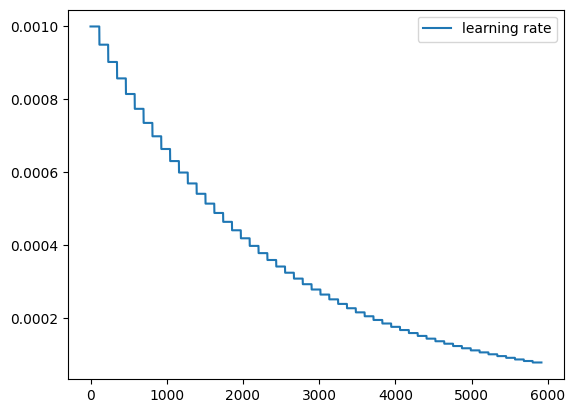

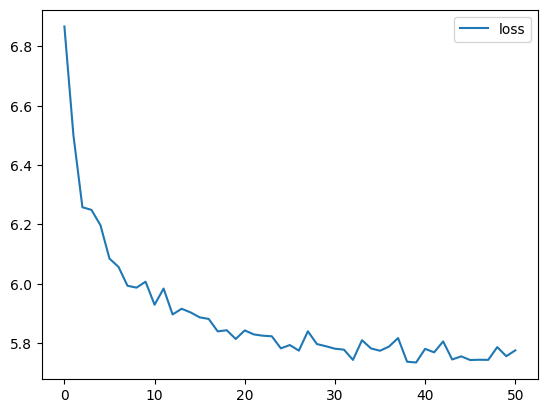

In [15]:
plt.plot(schedule_hist, label='learning rate')
plt.legend()
plt.show()
plt.plot(loss_hist, label = 'loss')
plt.legend()
plt.show()